In [49]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import scipy
from scipy import stats
import datetime
import numpy as np
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook, output_file, ColumnDataSource
from bokeh.models import HoverTool

In [2]:
#API containing spending data on all practices in the 14L(Manchester) CCG
r = requests.get("https://openprescribing.net/api/1.0/spending_by_practice/?code=5.1&org=14L&format=json")

#API containing patient size of all practices in the Manchester CCG
r2 = requests.get("https://openprescribing.net/api/1.0/org_details/?org_type=practice&org=14L&keys=total_list_size&format=json")

print(r.status_code,r2.status_code)

200 200


In [3]:
#converting json files from API into dataframes
df1 = pd.DataFrame(r.json())
df2 = pd.DataFrame(r2.json())

#merging the 2 dataframes
df = pd.merge(df1, df2, how='inner')

#Normalising quantity per 1000 patients
quantity_n = pd.Series(df.quantity/(0.001*df.total_list_size))

#merging normalised quantity into whole dataframe
df = pd.merge(df, quantity_n.rename('quantity_n'), how='inner', left_index=True, right_index=True)
df.head()

,row_name,row_id,actual_cost,setting,quantity,date,ccg,items,total_list_size,quantity_n
0,FIVE OAKS FAMILIY PRACTICE,P84004,2671.05,4,19905,2014-11-01,14L,386,8819,2257.058623
1,THE VALLANCE CENTRE,P84005,691.48,4,8591,2014-11-01,14L,195,7223,1189.394988
2,AILSA CRAIG MEDICAL CENTRE,P84009,1518.70,4,16980,2014-11-01,14L,355,9342,1817.597945
3,THE BORCHARDT MEDICAL CENTRE,P84010,1654.89,4,17123,2014-11-01,14L,373,11108,1541.501620
4,NORTHENDEN GROUP PRACTICE,P84012,2884.93,4,28188,2014-11-01,14L,634,11028,2556.039173


In [21]:
#Shows datatypes of variables
print(df.info())
df['date'] = pd.to_datetime(df['date'])
#df['row_name'] = df['row_name'].astype(str)

#shows if there are any null values in the dataframe
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5404 entries, 0 to 5403
Data columns (total 11 columns):
row_name           5404 non-null object
row_id             5404 non-null object
actual_cost        5404 non-null float64
setting            5404 non-null int64
quantity           5404 non-null int64
date               5404 non-null object
ccg                5404 non-null object
items              5404 non-null int64
total_list_size    5404 non-null int64
quantity_n         5404 non-null float64
outlier            5404 non-null bool
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 513.2+ KB
None


row_name           0
row_id             0
actual_cost        0
setting            0
quantity           0
date               0
ccg                0
items              0
total_list_size    0
quantity_n         0
outlier            0
dtype: int64

In [5]:
#Subsetting the data by timepoints or by practises using dictionaries
date={}
for i in df.date:
    date[i] = df[df.date == i]
prac={}
for i in df.row_name:
    prac[i] = df.row_name[df.row_name ==i]

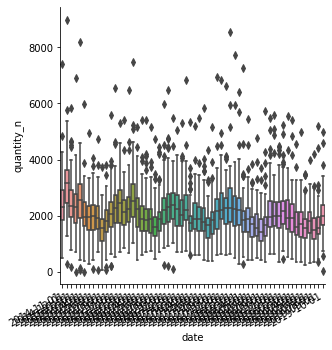

In [6]:
#boxplots of normalised quantity at each timepoint showing outliers
g = sns.catplot(x= 'date', y='quantity_n', data= df, kind = 'box')
g.fig.autofmt_xdate()

In [7]:
#extracting outliers for each time point using matplotlib.cbook's boxplot_stats, and putting it into a list
outliers = []
for i in date:
    outliers.append([y for stat in boxplot_stats(date[i]['quantity_n']) for y in stat['fliers']])

#Above creates a list of lists, this code will flatten this into a flat list
out = []
for sublist in outliers:
    for item in sublist:
        out.append(item)

#print(out, len(out))

In [8]:
#makes new column which determines if the quantity_n value is an outlier
df['outlier'] = df['quantity_n'].isin(out)

In [9]:
#making a dataframe with outlier values removed
df1 = df[~df['quantity_n'].isin(out)]

#making a dataframe of the outliers
dfo = df[df['quantity_n'].isin(out)]

#print(df.shape, df1.shape, dfo.shape)

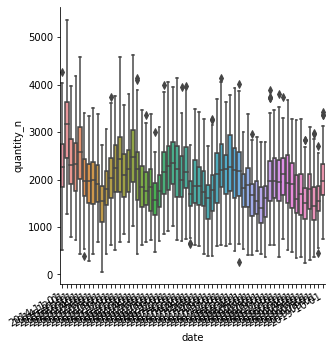

In [10]:
g = sns.catplot(x= 'date', y='quantity_n', data= df1, kind = 'box')
g.fig.autofmt_xdate()

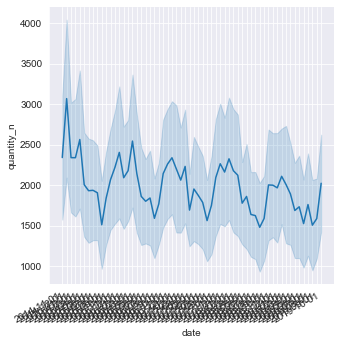

In [13]:
sns.set_style('darkgrid')
gmeans = sns.relplot(x='date', y='quantity_n', kind='line', ci='sd', data=df1)
gmeans.fig.autofmt_xdate()

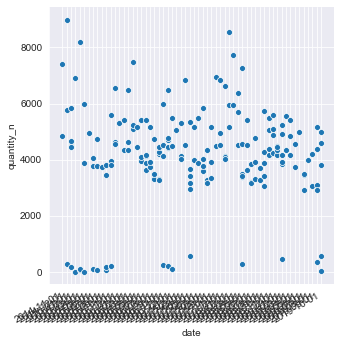

In [14]:
goutliers = sns.relplot(x='date', y='quantity_n', kind='scatter', ci='sd', data=dfo)
goutliers.fig.autofmt_xdate()

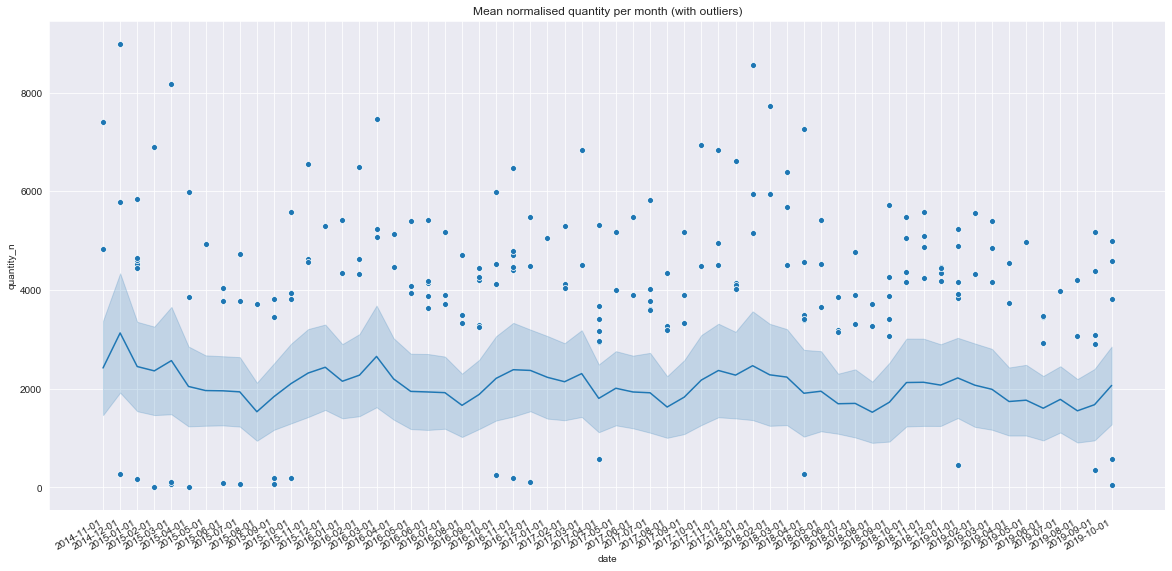

In [15]:
fig = plt.figure(figsize=(20,10))

sns.set_style('darkgrid')
sns.lineplot(x='date', y='quantity_n', ci='sd', data=df),
sns.scatterplot(x='date', y='quantity_n', data=dfo)
plt.title('Mean normalised quantity per month (with outliers)')


fig.autofmt_xdate()


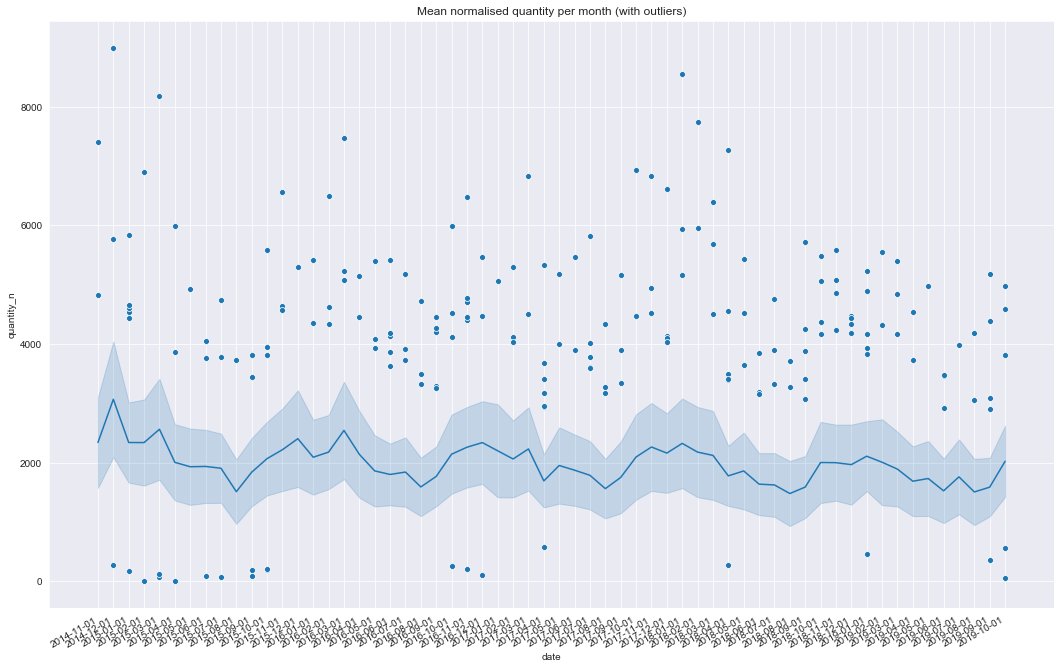

In [16]:
fig = plt.figure(figsize=(18,12))

sns.set_style('darkgrid')
sns.lineplot(x='date', y='quantity_n', ci='sd', data=df1),
sns.scatterplot(x='date', y='quantity_n', data=dfo)
plt.title('Mean normalised quantity per month (with outliers)')
fig.autofmt_xdate()

In [ ]:
#making a dataframe of general stats of the data
dfstats=df.groupby('date')['quantity_n'].describe().reset_index()
dfstats.head()

#same as above but with outliers removed (df1)
df1stats=df1.groupby('date')['quantity_n'].describe().reset_index()
df1stats.head()

#convert data type for the date column into datetime
df1stats['date'] = pd.to_datetime(df1stats['date'])
dfo['date'] = pd.to_datetime(dfo['date'])

#create columns for 1std over and under the mean
df1stats['1std.over']=(df1stats['mean'] + df1stats['std'])
df1stats['1std.under']=(df1stats['mean'] - df1stats['std'])

In [159]:
#create a CDS for bokeh to interact with pandas DF
source = ColumnDataSource(df1stats)
source2 = ColumnDataSource(dfo)

#output_file('Mean normalised quantity per month, with outliers. (mouse-over for values).html')
output_notebook()

#creating a bokeh figure
plot = figure(title='Mean normalised quantity per month, with outliers. (mouse-over for values)', x_axis_label='date', y_axis_label='mean quantity',
           x_axis_type='datetime')

#creating each plot
mean = plot.line('date','mean',line_color='red', source=source)
outliers = plot.circle('date','quantity_n', source=source2, size =5)
uppcerci = plot.line('date', '1std.over', line_dash = 'dashed', source=source)
lowerci = plot.line('date', '1std.under', line_dash = 'dashed', source=source)

#configuring mouse-over tooltip
tooltips = [
    ('Date','@date{%F}'),
    ('Normalised quantity', '@quantity_n{0,0.000}'),
    ('practice','@row_name')
]
formatters = {'date':'datetime'}
plot.add_tools(HoverTool(tooltips=tooltips, formatters=formatters, renderers=[outliers]))
           
tooltips2= [
    ('Date', '@date{%F}'),
    ('Mean normalised quantity', '@mean{0,0.000}')
]
formatters2 = {'date':'datetime'}
plot.add_tools(HoverTool(tooltips=tooltips2, formatters=formatters2, mode='vline', renderers=[mean]))

show(plot)

Loading BokehJS ...